In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
from collections import deque
import math
import random

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Implementing the DQN algorithm
I've chosen the mountain car environment to try out the NFQ-algorithm
Some learning highlights:
* Hint-to-goal heuristic seems crucial for the success
* Make sure to have cost & min Q / reward max Q in all places.
* The number of episodes + increment fed to the training process in each batch seems to hav a large impact
* Continuing/stopping the training at the right time point is crucial. I've achieved good results with this implementation, but then ruined a good trained NFQ agent

In [4]:
import gym
# Set up environment and do a test run
env = gym.make('CartPole-v0')

In [5]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
if True:
    env.reset()
    n_transitions = 200

    for i in range(n_transitions):
        state, reward, done, _ = env.step(env.action_space.sample())
        env.render()
        if done:
            env.reset()

In [30]:
class DQNLearningAgent():
    def __init__(self,env,discount_factor, epsilon, qnet_instant, qnet_delayed):
        self.env = env
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.qnet_instant = qnet_instant
        self.qnet_delayed = qnet_delayed
        self.x_success_range = 2.4
        self.theta_success_range = 8 * 2 * math.pi / 360
        
        self.x_threshold = 2.4
        self.theta_threshold_radians = 12/180*math.pi
    
    def step(self, state, target=False):
        if (target):
            q_s = self.qnet_delayed.get_qs(state)
            action = np.argmin(q_s)
        else:
            q_s = self.qnet_instant.get_qs(state)
            self.epsilon = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            if random.random() > self.epsilon:
                action = np.argmin(q_s)
            else:
                action = random.randint(0,1)

        new_state, reward, done, info = self.env.step(action) 
        # Convert rewards to cost in the interval (0.0, 1,0)
        x = new_state[0]
        theta = new_state[2]
        cost = 0.01
        if (x< -self.x_threshold or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians):
            #done = True
            cost = 1
        # Goal States (S+)
        elif (-self.x_success_range < x < self.x_success_range
              and -self.theta_success_range < theta < self.theta_success_range):
            #done = False
            cost = 0
        return action, cost, new_state, done, info

    def run_one_episode(self, target=False):
        episode = []
        done = False
        total_cost = 0
        state = self.env.reset()
        
        for _ in range(500):
            # get best action from the NFQ net
            action, cost, new_state, done, info = self.step(state, target)
           
            episode.append((state, action, cost, new_state, done, info))
            # Update state
            state = new_state

            total_cost += cost
            if done:
                break
            #if 'TimeLimit.truncated' in info:
            #    #print(info)
            #    break
            
        return episode, total_cost
    
    def generate_experiences(self, n_episodes):
        experiences=[]
        for _ in range(n_episodes):
            episode, _ = self.run_one_episode()
            experiences.extend(episode)
        return experiences
    
    def get_goal_experience(self, size):
        # Hint-to-goal heuristic with values extracted from env
        goal_experiences = []
        
        for i in range(size):
            goal_experiences.append(np.array([np.random.uniform(-0.1, 0.1), 
                                              np.random.normal(), 
                                              np.random.uniform(-self.theta_success_range, self.theta_success_range), 
                                              np.random.normal(), 
                                              np.random.randint(2)]))
        goal_targets = np.zeros(size, dtype = np.float32)
        return np.array(goal_experiences), goal_targets
                            

In [31]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Copying the neural network from Riedmiller 2005
        self.MLP = nn.Sequential(
            nn.Linear(5, 5),
            nn.Sigmoid(),
            nn.Linear(5, 5),
            nn.Sigmoid(),
            nn.Linear(5, 5),
            nn.Sigmoid(),
            nn.Linear(5, 1),
        )
          # Initialize weights to [-0.5, 0.5]
        def init_weights(m):
            if type(m) == nn.Linear:
                torch.nn.init.uniform_(m.weight, -0.5, 0.5)
              
        self.MLP.apply(init_weights)

    def forward(self, x):
        
        logits = self.MLP(x.to(device))
        return logits
    
    def get_qs(self, state):
        qs = np.array([self.MLP(torch.cat([torch.FloatTensor(state).to(device), 
                                           torch.FloatTensor([i]).to(device)], 
                                          dim=0)).cpu().detach().numpy() for i in range(2)]).flatten()
        return qs

In [32]:
def sample_pattern_set(experiences, model, discount_factor, device, n_sample):
   
    state_b, action_b, cost_b, next_state_b, done_b,_ = zip(*random.sample(experiences, n_sample))
    done_b = tuple([float(done) for done in done_b])
    state_b = torch.tensor(state_b, device=device)
    action_b = torch.tensor(action_b, device=device)
    cost_b = torch.tensor(cost_b, device=device)
    next_state_b = torch.tensor(next_state_b, device=device)
    done_b = torch.tensor(done_b, device=device)

    # Create the input_l = sl, ul
    state_action_b = torch.cat([state_b, action_b.unsqueeze(1)], 1)

    # Compute minb Qk(sl, b)
    q_next_state_0_b = model(torch.cat([next_state_b, torch.zeros(n_sample, 1, device=device)], 1)).squeeze()
    q_next_state_1_b = model(torch.cat([next_state_b, torch.ones(n_sample, 1, device=device)], 1)).squeeze()
    q_next_state_b,_ = torch.min(torch.stack([q_next_state_0_b, q_next_state_1_b]),dim=0)
    
    # Create the target_l = c(sl, ul, sl) +γ minb Qk(sl, b)
    with torch.no_grad():
        target_q_values = cost_b + discount_factor * q_next_state_b * (1-done_b)

    return state_action_b, target_q_values

def train_loop(agent, loss_fn, optimizer, discount_factor, device):
    losses=[]
    global steps_done
    N_batches = 10000
    n_sample=100
    state = agent.env.reset()
    experiences = []
    
    for i_batch in range(N_batches):
        # Sample experiences from replay buffer
        action, cost, new_state, done, info = agent.step(state)
        experiences.append((state, action, cost, new_state, done, info))
        if done:
            state = agent.env.reset()
        if (len(experiences) > n_sample):
        
            state_actions, target_q_values = sample_pattern_set(experiences, 
                                                      agent.qnet_delayed, 
                                                      discount_factor,
                                                      device, n_sample)
   
        
            pred = agent.qnet_instant(state_actions).squeeze()

            loss = loss_fn(pred, target_q_values)
            losses.append(loss.item())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i_batch%100 == 0:
                success_rate = test_loop(NFQagent, 100)
                if (success_rate >= 99.0):
                    break
            steps_done +=1

            if i_batch % TARGET_UPDATE == 0:
                NFQagent.qnet_delayed.load_state_dict(NFQagent.qnet_instant.state_dict())
    return losses


def test_loop(agent, n_trials):
    success = 0.
    episode_lengths=[]
    for i in range (n_trials):
        episode, total_cost = agent.run_one_episode(target=True)
        done = episode[-1][-2]
        info = episode[-1][-1]
        episode_lengths.append(len(episode))
        if done and ('TimeLimit.truncated' in info and info['TimeLimit.truncated']):
            success+=1.
        
    success /= n_trials
    print(f"Test run, average length: {(np.mean(episode_lengths)):>0.1f}, max: {(np.max(episode_lengths)):>0.1f}")
    print(f"Success rate: {(100*success):>0.1f}%")
    return success*100

In [35]:
policy_net = NeuralNetwork().to(device)
target_net = NeuralNetwork().to(device)
target_net.load_state_dict(policy_net.state_dict())
gamma = 0.95

GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
steps_done = 0

TARGET_UPDATE = 100
loss_fn=nn.MSELoss()
optimizer = torch.optim.Rprop(policy_net.parameters())

NFQagent = DQNLearningAgent(env,gamma, EPS_START, policy_net, target_net)

In [36]:
losses=[]
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    losses.extend(train_loop(NFQagent, loss_fn, optimizer, gamma, device))
    success_rate = test_loop(NFQagent, 100)
    if (success_rate >= 99.0):
        break
print("Done!")

Epoch 1
-------------------------------
Test run, average length: 9.4, max: 11.0
Success rate: 0.0%
Test run, average length: 9.5, max: 11.0
Success rate: 0.0%
Test run, average length: 9.5, max: 11.0
Success rate: 0.0%
Test run, average length: 9.4, max: 11.0
Success rate: 0.0%
Test run, average length: 9.5, max: 11.0
Success rate: 0.0%
Test run, average length: 9.2, max: 11.0
Success rate: 0.0%
Test run, average length: 9.3, max: 11.0
Success rate: 0.0%
Test run, average length: 9.5, max: 11.0
Success rate: 0.0%
Test run, average length: 9.3, max: 11.0
Success rate: 0.0%
Test run, average length: 9.4, max: 11.0
Success rate: 0.0%
Test run, average length: 9.3, max: 11.0
Success rate: 0.0%
Test run, average length: 9.4, max: 11.0
Success rate: 0.0%
Test run, average length: 9.2, max: 11.0
Success rate: 0.0%
Test run, average length: 9.4, max: 12.0
Success rate: 0.0%
Test run, average length: 9.4, max: 11.0
Success rate: 0.0%
Test run, average length: 9.4, max: 11.0
Success rate: 0.0%


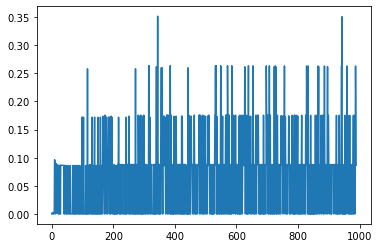

In [21]:
plt.figure()
plt.plot(losses)

In [ ]:
# Do a test run using the trained NFQ agent
test_loop(NFQagent, 500)

In [78]:
# For visualization
state = env.reset()
n_transitions = 1000

for i in range(n_transitions):
    q_s = np.array([NFQagent.nfq_net(torch.cat([torch.FloatTensor(state), torch.FloatTensor([i])], dim=0)).detach().numpy() for i in range(2)]).flatten()
    action = np.argmin(q_s)
    #print(action, q_s)
    state, reward, done, info = env.step(action)
    
    env.render()
    if done:
        if 'TimeLimit.truncated' in info:
            print(info)
        else:
            print('Terminated: Failed')
        env.reset()

{'TimeLimit.truncated': True}
{'TimeLimit.truncated': True}
{'TimeLimit.truncated': True}
{'TimeLimit.truncated': True}
{'TimeLimit.truncated': True}
